
###    1. Read the dataset
###    2. Visualize using Zero Crossing rate of some sample audio files
###    3. Extract features using Zero Crossing rate for all audio files
###   4. Imputation of Null values using Zero imputation and KNN imputation
###    5. Performing: PCA on Zero imputation with Kmeans clustering
###       PCA on KNN imputation with:
####       - KMeans
####       - Agglomerative CLustering
####       - DBSCAN
####       - MeanShift
###       TSNE on Zero Imputation
####        - KMeans 
###    6. Silhoutte scores of each.
       

## Import libraries

In [ ]:


from IPython.display import Audio
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale


from sklearn.impute import KNNImputer
%matplotlib inline
import numpy as np
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import IPython.display as ipd
import plotly as py
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")

import os

## Task 1: Read train.csv file and train folder for audios

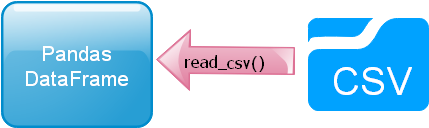

In [7]:
dirname = '../input/hindi-speech-classification/dataset/train'        
d = pd.read_csv("../input/hindi-speech-classification/dataset/train.csv")
d['file_id'] = d['file_id'].apply(lambda x: os.path.join(dirname,x))

In [8]:
d.head(10)

,file_id,gender
0,../input/hindi-speech-classification/dataset/t...,male
1,../input/hindi-speech-classification/dataset/t...,male
2,../input/hindi-speech-classification/dataset/t...,male
3,../input/hindi-speech-classification/dataset/t...,female
4,../input/hindi-speech-classification/dataset/t...,male
5,../input/hindi-speech-classification/dataset/t...,male
6,../input/hindi-speech-classification/dataset/t...,male
7,../input/hindi-speech-classification/dataset/t...,female
8,../input/hindi-speech-classification/dataset/t...,male
9,../input/hindi-speech-classification/dataset/t...,female


male      1664
female     334
Name: gender, dtype: int64


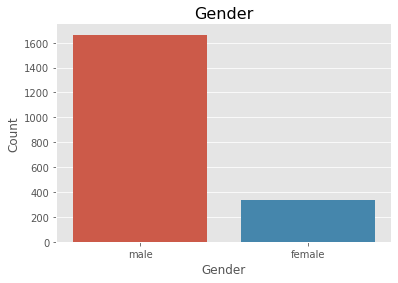

In [130]:
print(d["gender"].value_counts())
plt.title('Gender', size=16)
sns.countplot( d.gender)
plt.ylabel('Count', size=12)
plt.xlabel('Gender', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

### Male count is much higher than female count. Hence the data is imbalanced.

In [10]:

for dirname, _, filenames in os.walk('/kaggle/input/hindi-speech-classification/dataset/train'):
    for filename in filenames:
        print(os.path.join(dirname, filename))




/kaggle/input/hindi-speech-classification/dataset/train/common_voice_hi_26236348.mp3
/kaggle/input/hindi-speech-classification/dataset/train/common_voice_hi_25982670.mp3
/kaggle/input/hindi-speech-classification/dataset/train/common_voice_hi_25982602.mp3
/kaggle/input/hindi-speech-classification/dataset/train/common_voice_hi_24758462.mp3
/kaggle/input/hindi-speech-classification/dataset/train/common_voice_hi_25935932.mp3
/kaggle/input/hindi-speech-classification/dataset/train/common_voice_hi_25998803.mp3
/kaggle/input/hindi-speech-classification/dataset/train/common_voice_hi_26044000.mp3
/kaggle/input/hindi-speech-classification/dataset/train/common_voice_hi_26326512.mp3
/kaggle/input/hindi-speech-classification/dataset/train/common_voice_hi_25242412.mp3
/kaggle/input/hindi-speech-classification/dataset/train/common_voice_hi_24026514.mp3
/kaggle/input/hindi-speech-classification/dataset/train/common_voice_hi_23839871.mp3
/kaggle/input/hindi-speech-classification/dataset/train/common_vo

## Task 2: Select 2 samples for each female and male voices, plot zero crossing rate.
## Comment your inferences.
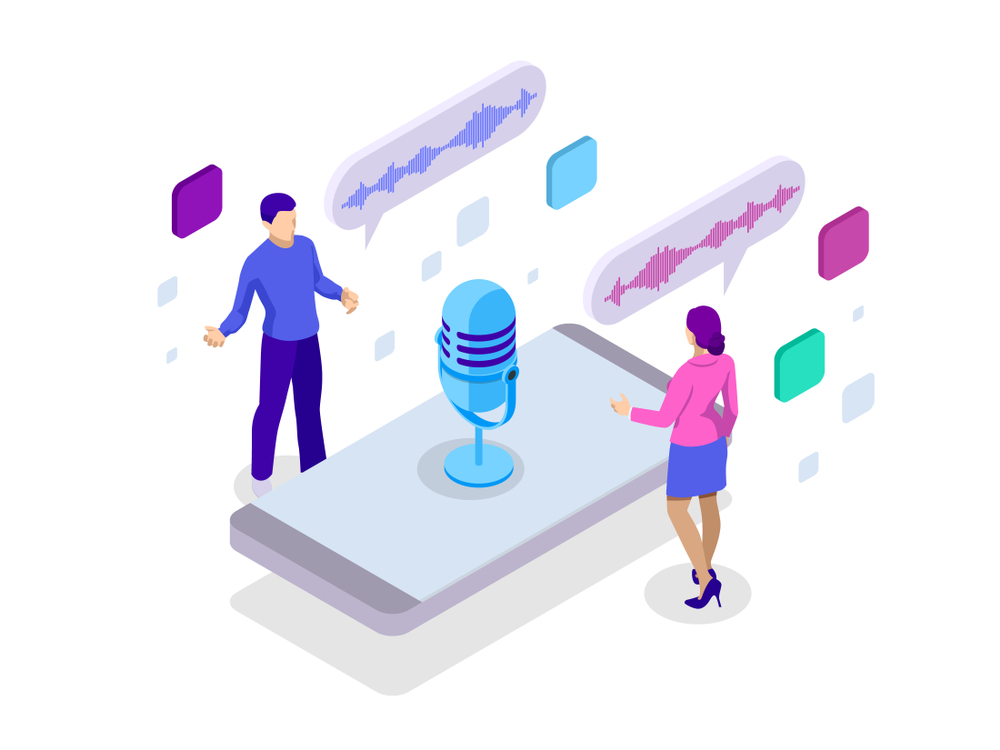

In [11]:
def create_Zero_crossing_rate(data, sr, i):
    
    zero_crossings = librosa.zero_crossings(data)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.figure(figsize=(10, 3))
    plt.title('Zero Crossing Rate of audio {} '.format(i), size=15)
    zcrs = librosa.feature.zero_crossing_rate(data)
    plt.plot(zcrs[0])
    plt.show()   

In [12]:
def create_waveplot(data, sr, i):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {}'.format(i), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

### Two samples for Male voices

Sum of zero crossing  13421


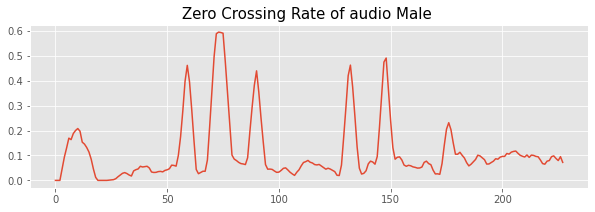

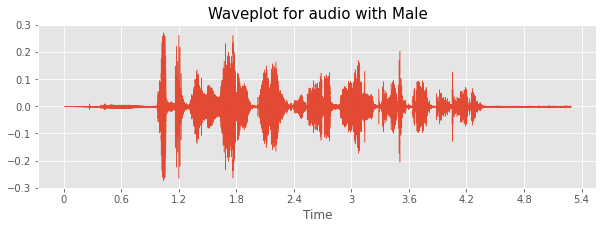

In [13]:
MALE_1 = d[(d['gender']=='male') ]
Male1 = MALE_1.sample()
x= Male1.iloc[0].file_id+".mp3"
info= "Male"
data, sampling_rate = librosa.load(x)
create_Zero_crossing_rate(data, sampling_rate, info)
create_waveplot(data, sampling_rate, info)
Audio(x)

Sum of zero crossing  9211


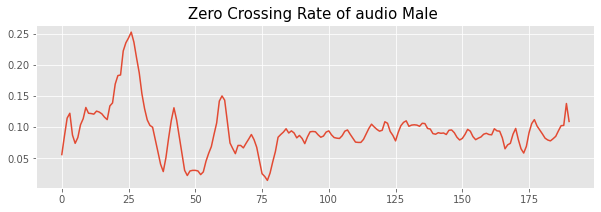

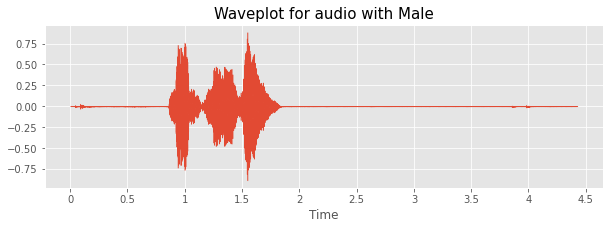

In [14]:
MALE_2 = d[(d['gender']=='male') ]
Male2 = MALE_2.sample()
x= Male2.iloc[0].file_id+".mp3"
info= "Male"
data, sampling_rate = librosa.load(x)
create_Zero_crossing_rate(data, sampling_rate, info)
create_waveplot(data, sampling_rate, info)
Audio(x)

### Two samples for Female voices

Sum of zero crossing  18783


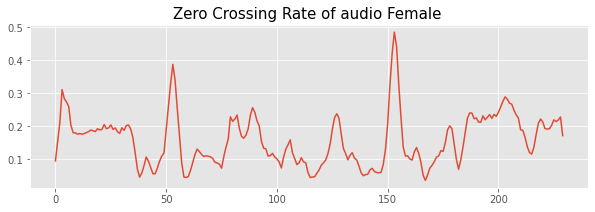

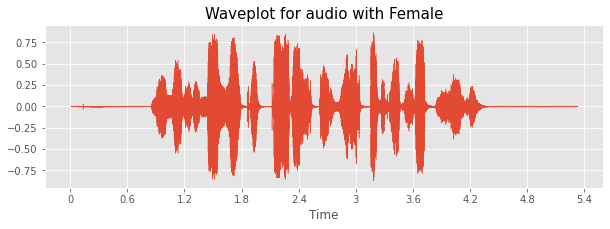

In [15]:
FEMALE_1 = d[(d['gender']=='female') ]
Female1 = FEMALE_1.sample()
x= Female1.iloc[0].file_id+".mp3"
info= "Female"
data, sampling_rate = librosa.load(x)
create_Zero_crossing_rate(data, sampling_rate, info)
create_waveplot(data, sampling_rate, info)
Audio(x)

Sum of zero crossing  6359


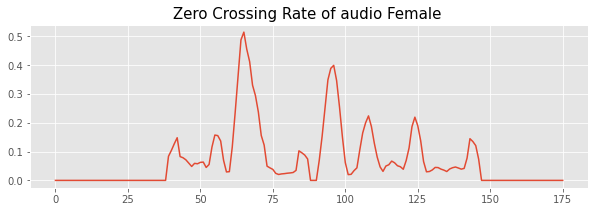

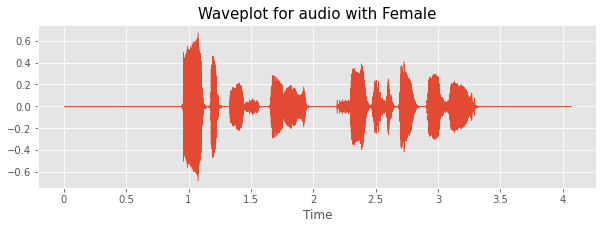

In [16]:
FEMALE_1 = d[(d['gender']=='female') ]
Female1 = FEMALE_1.sample()
x= Female1.iloc[0].file_id+".mp3"
info= "Female"
data, sampling_rate = librosa.load(x)
create_Zero_crossing_rate(data, sampling_rate, info)
create_waveplot(data, sampling_rate, info)
Audio(x)

### Inference: As Zero crossing rate is the number of times the signal changes it value from positive to negative or vice versa divided by the length of the frame, we observe the presence of speech through ZCR.

## 3. Extract zero crossing rate features for all audios.

In [17]:
def all_create_zero_cross_rating_features(x):
    zcrs = []
    try:
        data , sr = librosa.load(x)
        zcrs = librosa.feature.zero_crossing_rate(data)[0]
    except:
        print('Error reading audio')
    return zcrs

In [24]:

All_audios = pd.DataFrame((d['file_id']+'.mp3').apply(lambda a: all_create_zero_cross_rating_features(a)).tolist())

In [25]:
All_audios.head(10)

,0,1,2,3,4,5,6,7,8,9,...,429,430,431,432,433,434,435,436,437,438
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008301,0.052246,0.052246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013672,0.071777,0.071777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.054688,0.089355,0.127930,0.170410,0.159180,0.170898,0.182617,0.188477,0.192871,0.191406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.148926,0.307617,0.466797,0.622559,0.627930,0.621094,0.610352,0.570312,0.527832,0.504395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.061035,0.138672,0.261230,0.370117,0.393555,0.404297,0.347168,0.248535,0.187988,0.127441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.090332,0.121094,0.161133,0.151367,0.153320,0.159668,0.142578,0.127441,0.118164,0.117676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.085938,0.097656,0.120605,0.150391,0.091309,0.105957,0.142578,0.153809,0.148926,0.238281,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.062012,0.110352,0.145508,0.165039,0.142090,0.130859,0.132812,0.145996,0.162109,0.168457,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.132324,0.241699,0.354980,0.441895,0.379883,0.341309,0.305664,0.297852,0.299316,0.287598,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
print(All_audios.shape, d.shape)

(1998, 439) (1998, 2)


In [27]:
All_audios.isnull().sum().sum()

518865

In [31]:
#All_audios.to_csv("All_audios.csv",index=False) #saving ZCR all audio dataframe as csv for future purposes

In [27]:
#All_audios= pd.read_csv("/kaggle/input/Allaudios/All_audios.csv") #reading ZCR all audio dataframe as csv if required

## Task 4: Impute the null values with two options:
##  a. Zero impute
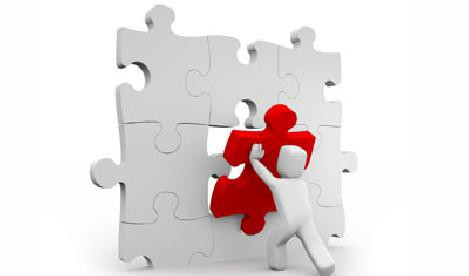

In [28]:
All_audios_impute = All_audios.copy()

In [29]:
All_audios_impute = All_audios_impute.fillna(0)

In [30]:
All_audios_impute.isnull().sum().sum()

0

## Demonstrating Correlation between different zero cross rating features after imputing null values with 0's

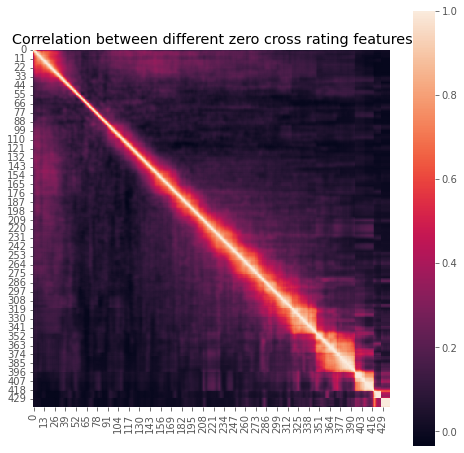

In [31]:
plt.figure(figsize=(8,8))
sns.heatmap(All_audios_impute.corr(), vmax=1, square=True)

plt.title('Correlation between different zero cross rating features')
plt.show()

##  b. KNN imputation 


### Define imputer

In [32]:
from sklearn.impute import KNNImputer

In [33]:
imputer = KNNImputer() #using default parameters 

### Fit on the dataset

In [34]:
All_audios_impute_KNN = imputer.fit_transform(All_audios)

In [35]:
All_audios_impute_KNN= pd.DataFrame(All_audios_impute_KNN)

In [36]:
All_audios_impute_KNN.isnull().sum().sum()

0

## 5. Apply following:
## a. PCA on zero impute and generate the clusters using KMeans.


####  **Create and fit Principal Components**

In [37]:
pca = PCA()
All_audios_impute_pca = pca.fit_transform(All_audios_impute)

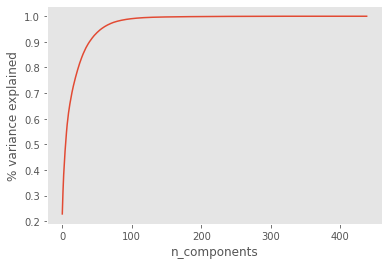

In [42]:

pca = PCA(n_components = All_audios_impute.shape[1])
pca_data = pca.fit_transform(All_audios_impute)

percent_var_explained = pca.explained_variance_/(np.sum(pca.explained_variance_))
cumm_var_explained = np.cumsum(percent_var_explained)

plt.plot(cumm_var_explained)
plt.grid()
plt.xlabel("n_components")
plt.ylabel("% variance explained")
plt.show()

In [43]:
cumm_var_explained

array([0.22816091, 0.3150828 , 0.38151407, 0.429601  , 0.47371177,
       0.51163817, 0.5458888 , 0.57647926, 0.60109873, 0.6232738 ,
       0.64213275, 0.6588451 , 0.67452463, 0.68903657, 0.70344112,
       0.71685714, 0.72847163, 0.73997143, 0.75069512, 0.76117691,
       0.77124759, 0.78087569, 0.79029582, 0.79947045, 0.80843409,
       0.81665235, 0.8245152 , 0.83229007, 0.83934435, 0.84636541,
       0.85309377, 0.85918851, 0.86514217, 0.87100694, 0.87672251,
       0.88181317, 0.88656665, 0.89112005, 0.89562148, 0.89978543,
       0.90369389, 0.90753301, 0.91124214, 0.91494335, 0.91851376,
       0.92175732, 0.92496406, 0.9279307 , 0.93078824, 0.93355254,
       0.93624838, 0.93883475, 0.94136415, 0.94379422, 0.94613962,
       0.94837441, 0.95043709, 0.95239027, 0.95427552, 0.95611895,
       0.95791994, 0.95961916, 0.96122277, 0.96280638, 0.96432971,
       0.96574808, 0.96710896, 0.96839899, 0.96967517, 0.97092044,
       0.97209147, 0.97322536, 0.97429006, 0.97530871, 0.97628

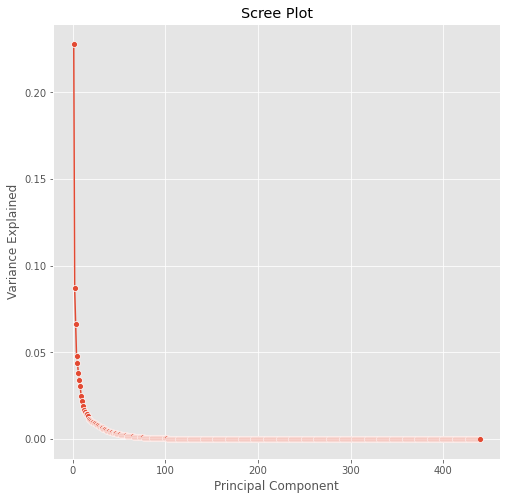

In [44]:
plt.figure(figsize=(8,8))
sns.lineplot(np.arange(pca.n_components_) + 1, pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Variance explained by Principal Components is not that great since rows have different sentences and genders.

#### Convert to dataframe

In [45]:
All_audios_impute_pca = pd.DataFrame(All_audios_impute_pca, columns=['PCA_'+str(i) for i in range(len(All_audios_impute.columns))])

In [46]:
All_audios_impute_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,...,PCA_429,PCA_430,PCA_431,PCA_432,PCA_433,PCA_434,PCA_435,PCA_436,PCA_437,PCA_438
0,-0.758371,-0.039369,0.096803,-0.148111,-0.065619,0.094073,0.085369,0.013914,-0.003518,0.011792,...,-4.365918e-16,-1.429520e-16,-3.182550e-17,2.713904e-17,5.152624e-17,6.940234e-17,4.384484e-17,1.219524e-16,8.921559e-17,3.222784e-16
1,-0.468756,-0.199873,0.181585,0.082558,-0.148450,0.037340,0.231982,-0.114463,-0.121369,-0.003185,...,7.774638e-17,-5.414960e-17,-2.820906e-16,8.092645e-17,1.343995e-16,2.620310e-16,-2.124918e-16,-3.726785e-17,-1.707698e-16,-2.737137e-16
2,1.097367,-1.095163,-0.306566,-0.655565,-0.493391,0.845137,0.897393,-0.970064,-0.089883,-0.215540,...,2.983919e-19,-3.311631e-18,2.579616e-19,9.968636e-19,1.518474e-18,2.528464e-18,3.209088e-18,-2.576699e-19,-2.134546e-18,-4.217130e-18
3,-0.308732,0.294423,-0.212587,0.144208,0.151917,0.092427,0.115992,-0.008326,0.148873,-0.215367,...,-1.080847e-17,8.944943e-17,-3.601046e-18,1.869316e-16,2.950422e-16,6.222476e-18,1.555113e-17,-1.212335e-16,-1.725412e-16,-1.599070e-16
4,2.226811,0.382371,1.856384,-0.363235,0.220474,0.321070,-0.670470,0.307124,0.208799,-0.231058,...,4.112116e-18,2.117229e-16,5.112617e-17,1.963377e-17,4.169456e-17,-1.265039e-16,1.888679e-16,1.135410e-16,-1.102565e-16,-6.524064e-17


## Correlation between PCA Components

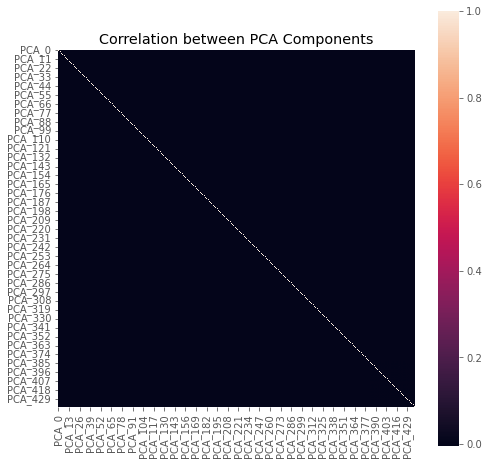

In [47]:
plt.figure(figsize=(8,8))
sns.heatmap(All_audios_impute_pca.corr(), vmax=1, square=True)

plt.title('Correlation between PCA Components')
plt.show()

### KMeans Clustering

In [48]:
optimal_value = []
for i in range(1, 11):
    kmeans_cluster = KMeans(n_clusters = i, init = 'k-means++', random_state = 32)
    kmeans_cluster.fit(All_audios_impute_pca.iloc[:, :3])
    optimal_value.append(kmeans_cluster.inertia_)

### The Elbow Method

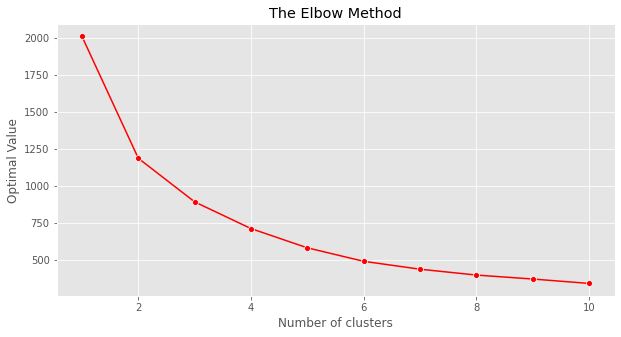

In [49]:
plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), optimal_value, marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Optimal Value')
plt.show()

In [50]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
final_kmeans = kmeans.fit_predict(All_audios_impute_pca.iloc[:, :3])

In [51]:
trace1 = go.Scatter3d(
    x= All_audios_impute_pca['PCA_0'],
    y= All_audios_impute_pca['PCA_1'],
    z= All_audios_impute_pca['PCA_2'],
    mode='markers',
     marker=dict(
        color = final_kmeans, 
        size= 10,
        line=dict(
            color= final_kmeans,
            width= 12
        ),
        opacity=0.8
     )
)
data_plotly = [trace1]
layout = go.Layout(
    title= 'Clusters wrt three PCA Components',
    scene = dict(
            xaxis = dict(title  = 'PCA 0'),
            yaxis = dict(title  = 'PCA 1'),
            zaxis = dict(title  = 'PCA 2')
        )
)
fig = go.Figure(data=data_plotly, layout=layout)
fig.show()

## b. PCA on KNN imputation with KMeans, Agglomerative, DBSCAN, and mean shift.


In [53]:
pca = PCA()
All_audios_impute_pcaKNN = pca.fit_transform(All_audios_impute_KNN)

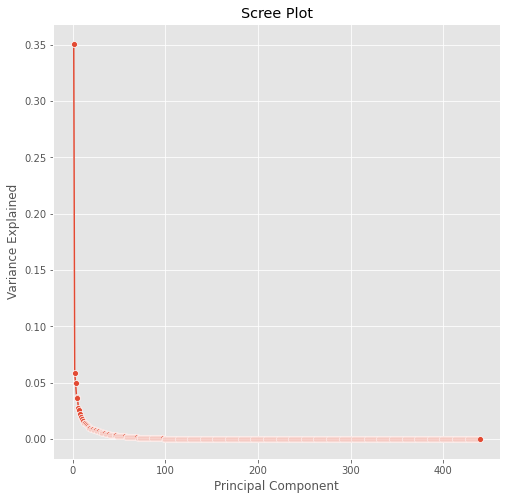

In [54]:
plt.figure(figsize=(8,8))
sns.lineplot(np.arange(pca.n_components_) + 1, pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

#### Convert to dataframe

In [55]:
All_audios_impute_pcaKNN = pd.DataFrame(All_audios_impute_pcaKNN, columns=['PCA_'+str(i) for i in range(len(All_audios_impute_KNN.columns))])
All_audios_impute_pcaKNN.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,...,PCA_429,PCA_430,PCA_431,PCA_432,PCA_433,PCA_434,PCA_435,PCA_436,PCA_437,PCA_438
0,-0.923332,-0.047261,0.062369,0.122029,-0.024794,0.107132,-0.045735,-0.129471,0.039800,-0.102179,...,3.260541e-17,2.943563e-17,-8.577800e-17,-2.136365e-18,-1.233011e-17,1.260171e-16,-8.672989e-17,1.168352e-17,7.961443e-17,1.964981e-16
1,-0.845137,-0.000493,-0.044179,0.172403,-0.070495,0.020929,-0.017570,-0.112072,0.143395,-0.098346,...,1.272580e-16,5.120467e-17,-1.536887e-16,4.450680e-17,7.032185e-18,-6.213012e-17,1.755136e-16,-8.306030e-17,2.496301e-17,3.185277e-16
2,0.527634,0.130736,0.260096,1.013400,0.118680,0.578905,0.449838,-0.811509,0.584382,-0.016766,...,-1.433154e-16,7.552910e-17,5.332760e-17,-7.276489e-17,-4.973883e-17,1.754002e-17,7.788407e-17,-2.621133e-17,4.928504e-17,1.351905e-17
3,-0.020844,-0.115921,0.082269,0.127796,0.217404,0.031016,0.050982,-0.052481,-0.280681,-0.113313,...,3.611701e-17,-3.763115e-17,9.092614e-17,7.577493e-17,-6.931851e-17,-7.182268e-18,9.708207e-17,2.794279e-17,-1.587480e-17,1.618997e-17
4,2.888741,-0.190247,1.053140,0.098507,-0.734264,0.366625,-0.644135,0.376219,-0.586329,-0.403806,...,4.978287e-17,6.452441e-17,-4.380552e-17,1.011510e-16,-2.059590e-17,-3.800095e-18,3.363975e-17,4.034084e-17,-2.367603e-19,-8.013540e-17


## Correlation between PCA Components

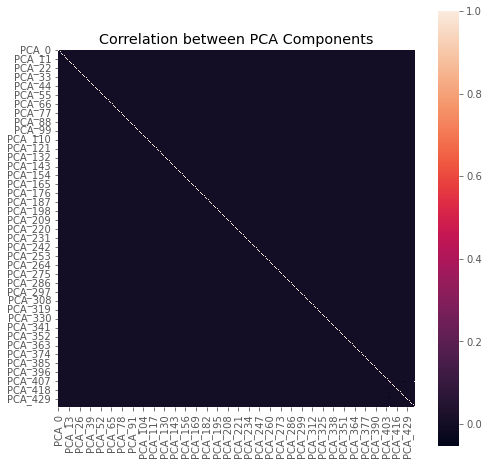

In [56]:
plt.figure(figsize=(8,8))
sns.heatmap(All_audios_impute_pcaKNN.corr(), vmax=1, square=True)

plt.title('Correlation between PCA Components')
plt.show()

## K-means

In [57]:
optimal_value = []
for i in range(1, 11):
    kmeans_cluster = KMeans(n_clusters = i, init = 'k-means++', random_state = 32)
    kmeans_cluster.fit(All_audios_impute_pcaKNN.iloc[:, :3])
    optimal_value.append(kmeans_cluster.inertia_)

### Elbow method

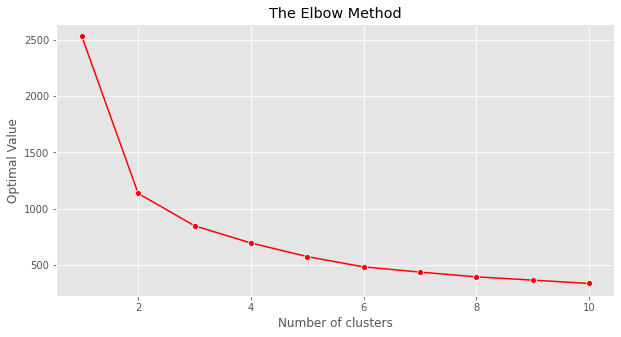

In [58]:
plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), optimal_value, marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Optimal Value')
plt.show()

In [59]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
final_kmeans = kmeans.fit_predict(All_audios_impute_pcaKNN.iloc[:, :3])

### The elbow for each component two clusters are highly seen and 3 or 4 can be used to create clusters, we selected 3 clusters 

In [60]:
trace1 = go.Scatter3d(
    x= All_audios_impute_pcaKNN['PCA_0'],
    y= All_audios_impute_pcaKNN['PCA_1'],
    z= All_audios_impute_pcaKNN['PCA_2'],
    mode='markers',
     marker=dict(
        color = final_kmeans, 
        size= 10,
        line=dict(
            color= final_kmeans,
            width= 12
        ),
        opacity=0.8
     )
)
data_plotly = [trace1]
layout = go.Layout(
    title= 'Clusters wrt three PCA Components',
    scene = dict(
            xaxis = dict(title  = 'PCA 0'),
            yaxis = dict(title  = 'PCA 1'),
            zaxis = dict(title  = 'PCA 2')
        )
)
fig = go.Figure(data=data_plotly, layout=layout)
fig.show()

### Agglomerative

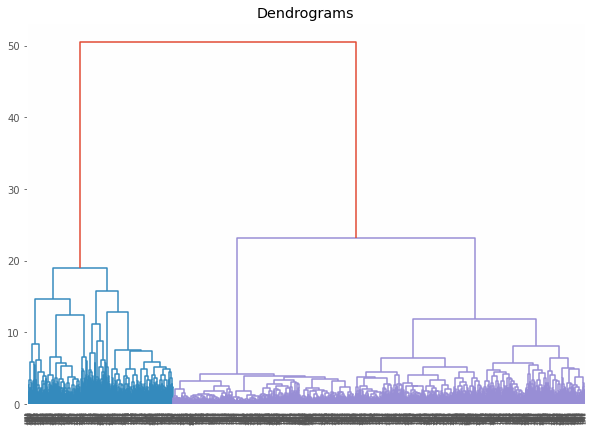

In [61]:
# Dendrogram for Hierarchical Clustering
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(All_audios_impute_pcaKNN, method='ward'))

## Dendrogram for Agglomerative Clustering

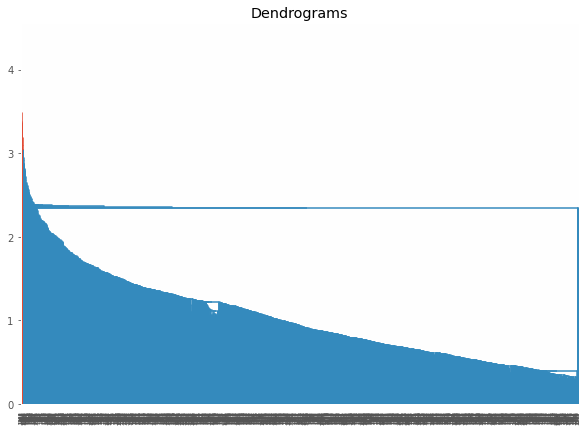

In [62]:
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(All_audios_impute_pcaKNN, method='single'))

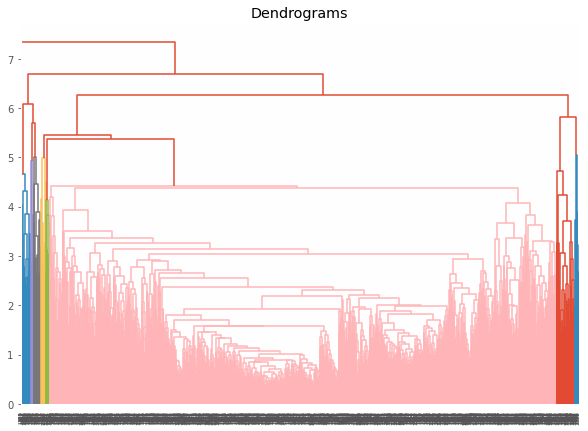

In [63]:
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(All_audios_impute_pcaKNN, method='complete'))

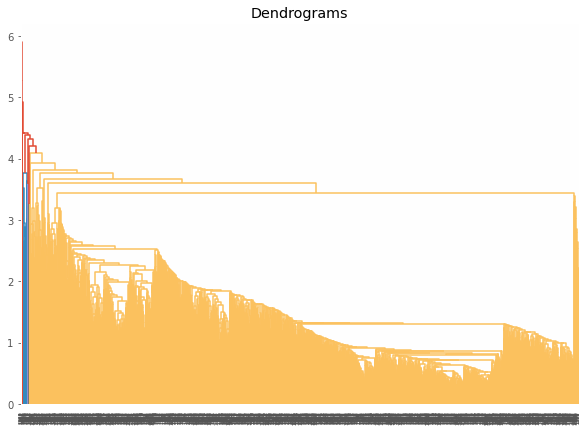

In [64]:
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(All_audios_impute_pcaKNN, method='average'))

## Best cluster number = 3 in ward

## Agglomerative clustering

In [123]:

from numpy import unique
from numpy import where
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=3)
yhat = model.fit(All_audios_impute_pcaKNN)
ag_l= model.labels_
clusters = unique(yhat)
final_agg = yhat.fit_predict(All_audios_impute_pcaKNN.iloc[:, :3])

In [66]:

trace1 = go.Scatter3d(
    x= All_audios_impute_pcaKNN['PCA_0'],
    y= All_audios_impute_pcaKNN['PCA_1'],
    z= All_audios_impute_pcaKNN['PCA_2'],
    mode='markers',
     marker=dict(
        color = final_agg, 
        size= 10,
        line=dict(
            color= final_agg,
            width= 12
        ),
        opacity=0.8
     )
)
data_plotly = [trace1]
layout = go.Layout(
    title= 'Clusters wrt three PCA Components',
    scene = dict(
            xaxis = dict(title  = 'PCA 0'),
            yaxis = dict(title  = 'PCA 1'),
            zaxis = dict(title  = 'PCA 2')
        )
)
fig = go.Figure(data=data_plotly, layout=layout)
fig.show()

### DBSCAN


In [67]:
!pip install kneed

1.8103981195633057


<Figure size 360x360 with 0 Axes>

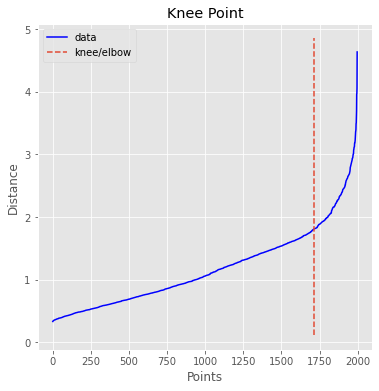

In [68]:
# parameter tuning for eps
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(All_audios_impute_pcaKNN)
distances, indices = neighbors.kneighbors(All_audios_impute_pcaKNN)
distances = np.sort(distances[:,10], axis=0)
from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(distances[knee.knee])

### Based on above we find eps value to be 1.81 

In [69]:
2*len(All_audios_impute_pcaKNN)

3996

In [70]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=1.8103981195633057)
# rule of thumb for min_samples: 2*len(df.columns)
final_db = model.fit_predict(All_audios_impute_pcaKNN)
clusters = unique(final_db)

In [71]:
clusters

array([-1,  0])

In [72]:

trace1 = go.Scatter3d(
    x= All_audios_impute_pcaKNN['PCA_0'],
    y= All_audios_impute_pcaKNN['PCA_1'],
    z= All_audios_impute_pcaKNN['PCA_2'],
    mode='markers',
     marker=dict(
        color = final_db, 
        size= 10,
        line=dict(
            color= final_db,
            width= 12
        ),
        opacity=0.8
     )
)
data_plotly = [trace1]
layout = go.Layout(
    title= 'Clusters wrt three PCA Components',
    scene = dict(
            xaxis = dict(title  = 'PCA 0'),
            yaxis = dict(title  = 'PCA 1'),
            zaxis = dict(title  = 'PCA 2')
        )
)
fig = go.Figure(data=data_plotly, layout=layout)
fig.show()

### Mean shift

In [117]:
from sklearn.cluster import  estimate_bandwidth
bandwidth = estimate_bandwidth(All_audios_impute_pcaKNN)

ms = MeanShift(bandwidth=bandwidth)
ms.fit(All_audios_impute_pcaKNN)
labels = ms.labels_
final_ms = ms.fit_predict(All_audios_impute_pcaKNN)


In [118]:
clusters = unique(final_ms)
clusters 

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [77]:

trace1 = go.Scatter3d(
    x= All_audios_impute_pcaKNN['PCA_0'],
    y= All_audios_impute_pcaKNN['PCA_1'],
    z= All_audios_impute_pcaKNN['PCA_2'],
    mode='markers',
     marker=dict(
        color = final_ms, 
        size= 10,
        line=dict(
            color= final_ms,
            width= 12
        ),
        opacity=0.8
     )
)
data_plotly = [trace1]
layout = go.Layout(
    title= 'Clusters wrt three PCA Components',
    scene = dict(
            xaxis = dict(title  = 'PCA 0'),
            yaxis = dict(title  = 'PCA 1'),
            zaxis = dict(title  = 'PCA 2')
        )
)
fig = go.Figure(data=data_plotly, layout=layout)
fig.show()

## c. T-SNE (t-distributed Stochastic Neighbor Embedding) on zero impute with KMeans.

In [83]:
from sklearn.manifold import TSNE

In [93]:
tsne = TSNE(n_components=3, verbose=1, random_state=123)
model = tsne.fit_transform(All_audios_impute) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1998 samples in 0.001s...
[t-SNE] Computed neighbors for 1998 samples in 0.184s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1998
[t-SNE] Computed conditional probabilities for sample 1998 / 1998
[t-SNE] Mean sigma: 0.263777
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.826927
[t-SNE] KL divergence after 1000 iterations: 1.311996


In [94]:
model.shape

(1998, 3)

In [95]:
model_tsne = pd.DataFrame({'C_0':model.T[0],'C_1':model.T[1],'C_2':model.T[2]})
                    

In [97]:
model_tsne.head()

,C_0,C_1,C_2
0,-4.941272,0.507036,-10.767069
1,-2.633969,-7.386036,-6.049191
2,1.481035,-23.496872,1.516305
3,-4.153650,13.961179,5.630487
4,21.933336,8.638537,1.342459


## KMeans Clusetring with one TSNE Component

In [99]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 132)
final_ts1 = kmeans.fit_predict(model_tsne.iloc[:,:1])

## KMeans Clusetring with three TSNE Component

In [100]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 132)
final_ts3 = kmeans.fit_predict(model_tsne.iloc[:,:3])

In [102]:

trace1 = go.Scatter3d(
    x= model_tsne['C_0'],
    y= model_tsne['C_1'],
    z= model_tsne['C_2'],
    mode='markers',
     marker=dict(
        color = final_ts3, 
        size= 10,
        line=dict(
            color= final_ts3,
            width= 12
        ),
        opacity=0.8
     )
)
data_plotly = [trace1]
layout = go.Layout(
    title= 'Clusters wrt three TSNE Components',
    scene = dict(
            xaxis = dict(title  = 'C 1'),
            yaxis = dict(title  = 'C 2'),
            zaxis = dict(title  = 'C 3')
        )
)
fig = go.Figure(data=data_plotly, layout=layout)
fig.show()

## 6. Apply silhouette score metric on the labels. Comment on the metric results. 


In [109]:
score_kemans_s = silhouette_score(All_audios_impute_pcaKNN.iloc[:, :3], final_kmeans)
print('Silhouette Score: %.4f' % score_kemans_s)

Silhouette Score: 0.4225


In [125]:
score_AGclustering_s = silhouette_score(All_audios_impute_pcaKNN.iloc[:, :3], ag_l, metric='euclidean')
print('Silhouette Score: %.4f' % score_AGclustering_s)

Silhouette Score: 0.3299


In [115]:
score_dbsacn_s = silhouette_score(All_audios_impute_pcaKNN.iloc[:, :3], final_db, metric='euclidean')
print('Silhouette Score: %.4f' % score_dbsacn_s)

Silhouette Score: 0.4645


In [126]:
score_m_s = silhouette_score(All_audios_impute_pcaKNN.iloc[:, :3], final_ms, metric='euclidean')
print('Silhouette Score: %.4f' % score_m_s)

Silhouette Score: -0.4734


In [128]:
score_t_s = silhouette_score(All_audios_impute_pca.iloc[:, :3], final_ts1, metric='euclidean')
print('Silhouette Score: %.4f' % score_t_s)

Silhouette Score: 0.2465


In [129]:
score_t_s = silhouette_score(All_audios_impute_pca.iloc[:, :3], final_ts3, metric='euclidean')
print('Silhouette Score: %.4f' % score_t_s)

Silhouette Score: 0.2470


### Comments:
* As, Silhouette Score is a metric to evaluate the performance of clustering algorithm. 

* It uses compactness of individual clusters(intra cluster distance) and separation amongst clusters (inter cluster distance) to measure an overall representative score of how well our clustering algorithm has performed.

*  The Silhouette Coefficient ranges from [-1,1]. The higher the Silhouette Coefficients (the closer to +1), the more is the separation between clusters. A negative value indicates that those samples might have been assigned to the wrong cluster.

* Hence we can see analyze results based on above scores. In our case DBSCAN works best.

## 7. Publish your notebook in that Kaggle dataset.

### PUBLISHED.